In [2]:
push!(LOAD_PATH, ".")

4-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "."

In [3]:
#using Distributed
#while Distributed.nprocs() < Sys.CPU_THREADS/2 + 1
#    Distributed.addprocs(1)
#end
#
#@everywhere resize!(LOAD_PATH, length($LOAD_PATH)), copyto!(LOAD_PATH, $LOAD_PATH)
#
#Distributed.nprocs()


In [4]:
#using Distributed
using Base.Threads
using FileIO
using PyPlot
#using Revise
using Distributions
using StatsBase
using BJRG
using CodecZlib
using Infections
using SparseArrays
using Twitter
import TwitterPlots
using TomekUtils

using PyPlot

import PyCall
PyCall.PyDict(matplotlib."rcParams")["pgf.rcfonts"] = false
#PyCall.PyDict(matplotlib."rcParams")["text.latex.preamble"] 
PyCall.PyDict(matplotlib."rcParams")["font.family"] = "lmodern" 

PyCall.PyDict(matplotlib."rcParams")["font.size"] = "8"
PyCall.PyDict(matplotlib."rcParams")["lines.markersize"] = 3
PyCall.PyDict(matplotlib."rcParams")["lines.linewidth"] = 1
PyCall.PyDict(matplotlib."rcParams")["legend.fontsize"] = "small"

PyCall.PyDict(matplotlib."rcParams")["savefig.bbox"] = "tight"
PyCall.PyDict(matplotlib."rcParams")["pgf.texsystem"] = "pdflatex"
PyCall.PyDict(matplotlib."rcParams")["text.usetex"] = true
PyCall.PyDict(matplotlib."rcParams")["pgf.preamble"] = [
         raw"\usepackage[utf8x]{inputenc}",
         raw"\usepackage[T1]{fontenc}",
         raw"\usepackage{lmodern}"
         ]

plot_dir = "plots/"
TwitterPlots.set_plot_dir(plot_dir)
TwitterPlots.plot_dir

half_plot_size = (2.75,2.75)
quarter_plot_size = (1,1)

bar_plot_size = (2.75, 1.5)
fat_plot_size = (2.75, 2.25)

density_plot_size = (2.75,1.75)

(2.75, 1.75)

In [5]:
adj_higgs = load("data/higgs.jld2")["adj"];

In [4]:
if true
    r1 = @spawn Twitter.follower_similar_scalar(adj_higgs,0.1,5.0);
    r2 = @spawn Twitter.follower_similar(adj_higgs);
    r3 = @spawn Twitter.follower_similar(adj_higgs, shuffled=true);

    save("data/estimates-higgs.jld2",
        "adj_sca", fetch(r1),
        "adj_est", fetch(r2),
        "adj_shu", fetch(r3),
        compress=true)
    finalize.([r1,r2,r3])
end
data = load("data/estimates-higgs.jld2")

adj_est_higgs = data["adj_est"];
adj_shu_higgs = data["adj_shu"];
adj_sca_higgs = data["adj_sca"];

In [ ]:
#size(adj_higgs), count(adj_higgs)

In [ ]:
TwitterPlots.degree_ecdf_plot(adj_higgs,"higgs", fig=figure(figsize=bar_plot_size))

In [81]:
gammas = exp10.(-1:0.02:1);
likelihoods = Vector{Float64}(undef, size(gammas))
Threads.@threads for i in 1:length(gammas)
  gamma = gammas[i]
  likelihood = Twitter.likelihood_scalar(adj_higgs, Twitter.follower_estimate_scalar(adj_higgs, gamma), gamma)
  likelihoods[i] = likelihood
end
  
#likelihoods = [Twitter.likelihood_scalar(adj_higgs, Twitter.follower_estimate_scalar(adj_higgs, gamma), gamma) for gamma in gammas];
gamma = gammas[argmax(likelihoods)]

0.6309573444801932

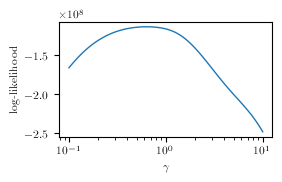

In [82]:
TwitterPlots.gamma_plot(gammas, likelihoods, "Higgs", fig=figure(figsize=bar_plot_size))

In [83]:
#PyCall.PyDict(matplotlib."rcParams")["font.size"] = "8"

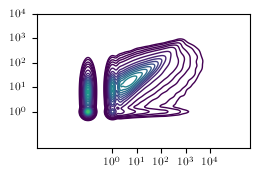

In [84]:
using KernelDensity

TwitterPlots.inoutdeg_corr_contour(adj_higgs, "higgs", fig=figure(figsize=density_plot_size))

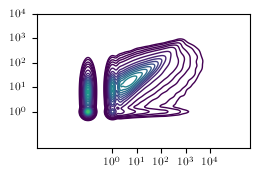

In [85]:
TwitterPlots.inoutdeg_corr_contour(adj_higgs, "higgs", fig=figure(figsize=density_plot_size))

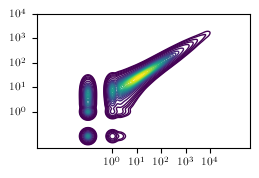

In [86]:
TwitterPlots.inoutdeg_corr_contour(adj_sca_higgs, "sca_higgs", fig=figure(figsize=density_plot_size))

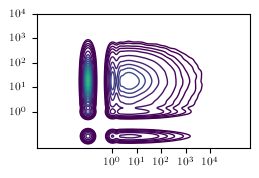

In [87]:
TwitterPlots.inoutdeg_corr_contour(adj_shu_higgs, "shu_higgs", fig=figure(figsize=density_plot_size))

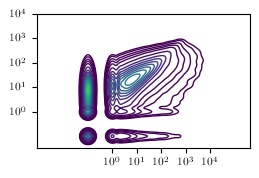

In [88]:
TwitterPlots.inoutdeg_corr_contour(adj_est_higgs, "est_higgs", fig=figure(figsize=density_plot_size))

In [89]:
#reload("TwitterPlots.jl")
if false
    Twitter.computeinfections("higgs", "data/infections_higgs.jld2", exp10.(-4:0.04:0),
        adj_higgs, adj_est_higgs, adj_shu_higgs, adj_sca_higgs, gamma);
end

#if true
#    Twitter.computeinfections("higgs", "data/infections_higgs.jld", logspace(-4,0,10^3), adj_higgs, adj_est_higgs, adj_shu_higgs, adj_sca_higgs)
#end
data = load("data/infections_higgs.jld2");

In [90]:
PyCall.PyDict(matplotlib."rcParams")["font.size"] = "8"

"8"

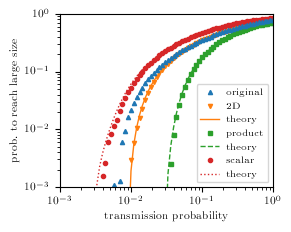

In [91]:
TwitterPlots.forward_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

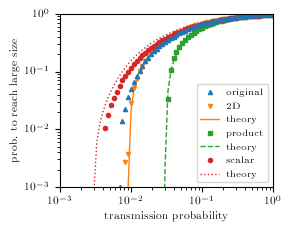

In [92]:
TwitterPlots.backward_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

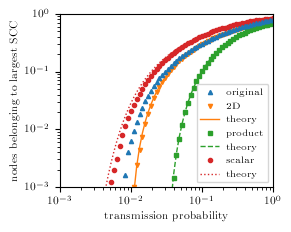

In [93]:
TwitterPlots.scc_plot(data, fig=figure(figsize=fat_plot_size))

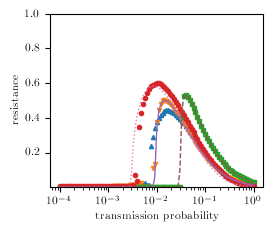

In [94]:
TwitterPlots.resistances_plot(data, fig=figure(figsize=fat_plot_size))

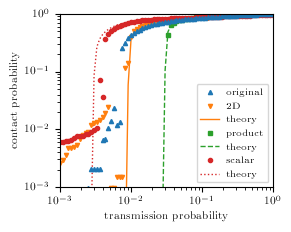

In [95]:
TwitterPlots.contacts_plot(data, fig=figure(figsize=fat_plot_size))

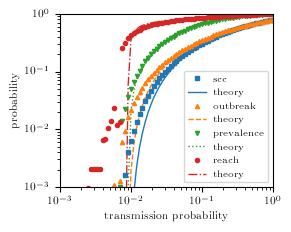

In [73]:
TwitterPlots.original_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

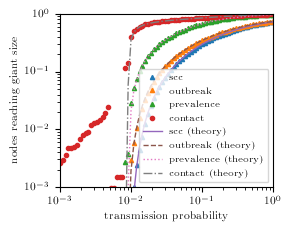

In [74]:
TwitterPlots.estimated_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

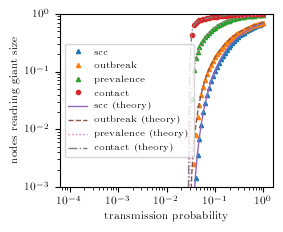

In [75]:
TwitterPlots.estimated_independent_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

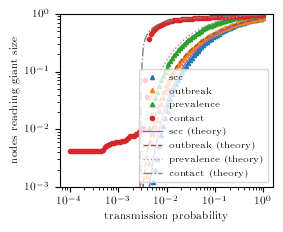

In [76]:
TwitterPlots.estimated_scalar_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

In [10]:

using Random
using TwitterCascades
N = size(adj_higgs,1)

rng = MersenneTwister(123)
#time_distribution = Uniform(0.9, 1.1)
time_distribution = Exponential(1)

start = 40001

receive_times = TwitterCascades.timed_cascade_multitry(rng, adj_higgs, start, time_distribution, 1, 0.0, forward=true)
receive_times .|> !isnan |> count

455939

In [82]:
@time receive_times = timed_cascade_multitry(rng, adj_higgs, start , time_distribution, 1, 0, forward=true)

  2.116214 seconds (66.54 k allocations: 151.470 MiB, 0.53% gc time, 2.74% compilation time)


456626-element Vector{Float32}:
 1.4432583
 1.275801
 1.4004403
 1.2213327
 1.2595501
 1.2317308
 1.2663932
 1.3143191
 1.3160915
 1.2485493
 ⋮
 2.9775026
 1.3170704
 2.3698597
 2.2852454
 1.5839404
 1.3687655
 2.2852454
 2.1525397
 2.2852454

In [22]:
sum(adj_higgs, dims=1)

1×456626 Matrix{Int64}:
 22  77  25  402  58  101  99  54  29  …  1  4  1  2  8  1  1  2  12  1  1  1

In [55]:
using Base.Threads

a  = zeros(10)
Threads.@threads for i = 1:10
  times = timed_cascade(rng, adj_higgs, i , time_distribution, forward=true)
  a = mean(times)
end